In [1]:
push!(LOAD_PATH, joinpath(Pkg.dir("SpectralClustering"), "docs"));

# Embedding

## Comparison between Ng Laplacian and ShiMalik Laplacian
Given a weight matrix $W$, the `ShiMalikLaplacian` embedding method obtains $V_1$, the $k$ eigenvectors corresponding to the $k$ smallest eigenvalues different from 0 of the matrix  $NL = D^{-\frac{1}{2}}(D-W)D^{-\frac{1}{2}}$. Then computes $X_1 = D^{\frac{1}{2}} V_1$ to obtain the solution of the generalized eigenvalue problem $(D-W)X_1 = \lambda D X_1$.

The `NgLaplacian` embedding method computes the $k$ eigenvectors corresponding to the $k$ largest eigenvalues of $L  = D^{-\frac{1}{2}}WD^{-\frac{1}{2}}$.

The eigenvectors obtained with both metods should be the same. The eigenvalues are shifted: the eigenvectors corresponding to the eigenvalue $0$ of $NL$ are the eigenvectors corresponding to the eigenvalue $1$ of $L$.

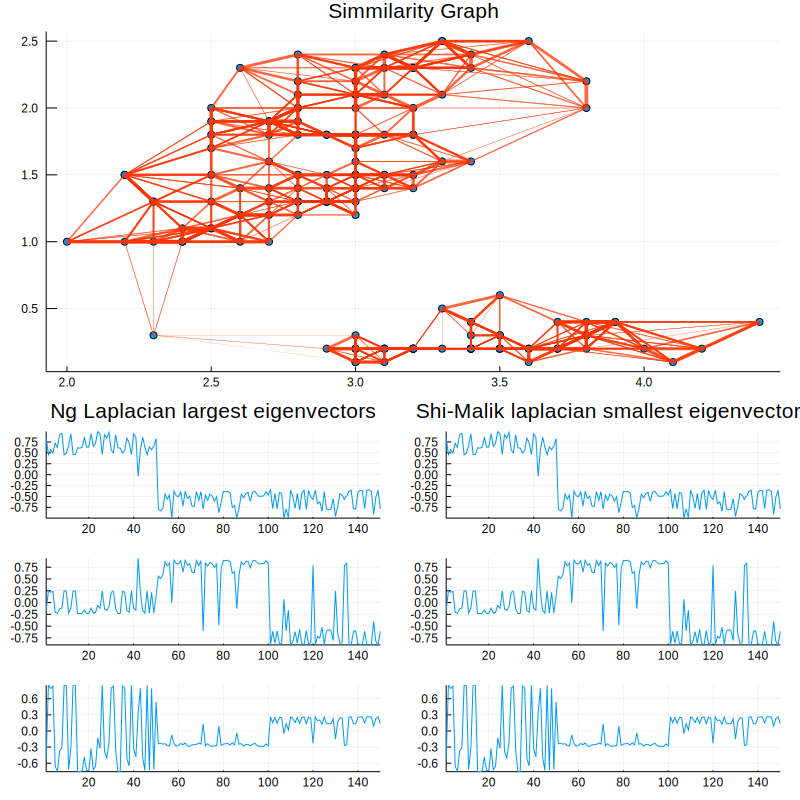

In [10]:
using RDatasets
using SpectralClustering
using Distances
function weight(i::Integer, neigh, v, m, l_scale)
    return exp.(-Distances.colwise(SqEuclidean(),m,v)./(l_scale[i].*l_scale[neigh]))
end

d             = dataset("datasets", "iris")
d             = convert(Matrix,d[:,[2,4]])'
knnconfig     = KNNNeighborhood(d,10)
l_scale       = local_scale(knnconfig, (v1,v2)->norm(v1-v2),d  ) + eps()
weight_oracle = (i,neigh,v,m)->weight(i,neigh,v,m,l_scale)
G             = create(knnconfig,weight_oracle,d);
ng_vec        = embedding(NgLaplacian(3), G)
sm_vec        = embedding(ShiMalikLaplacian(3),G);

using Plots
 
fig1 = Plots.plot(ng_vec[:,1:3], layout = (@layout grid(3,1)), legend=false)
title!(fig1.subplots[1], "Ng Laplacian largest eigenvectors")
fig2 = Plots.plot(sm_vec[:,1:3], layout = (@layout grid(3,1)), legend=false) 
title!(fig2.subplots[1], "Shi-Malik laplacian smallest eigenvectors")
plt           = SpectralClustering.plot(G,d) 
title!(plt, "Simmilarity Graph")
Plots.plot(plt, fig1,fig2,   layout =( @layout [a{1w}; grid(1,2){1w}]), size=(800,800)  )

## Segmentation Given Partial Grouping Constraints
If partial information of the clustering is available,  in [Segmentation Given Partial Grouping Constraints](#yu2004segmentation) the authors showed that it is possible to incorporate that information to the optimization problem that spectral clustering algorithms solve.

Let $X \in R^{N \times K}$ a partition matrix where $X=\left[ X_1,...,X_K \right]$ and $X(i,l) = 1$ if $i \in V_l$ and 0 otherwise. Given that every $X_t$ is a binary indicator for partition $V_t$ and since envery pattern is asigned to one partition: $X \mathbf{1}_K = \mathbf{1}_N$.

Let $C=\left\{ c_1, c_2, ...,c_n \right\}$ be the partial information of the clustering. $c_i$ is a set of the patterns belonging to the same cluster. Each set produces |c_i| - 1 constraints. Each contraint  can be represented by an $N \times 1$ vector $U_k$  with only two non zero elements $U_k(i) = 1$ and $U_k(j)=-1$ if $i,j \in c_k$. Let $U$ be the matrix forme by every contraint vector located in the columns. Then the constraints satisfy $U^T X = 0$.

The constrained clustering problem for the normalized cuts criterion is the following:
$$
\begin{array}{cc}
  \max & \frac{1}{K} \sum\limits_{l=1}^K \dfrac{X_l^T W X_l}{X_l^T D X_l} \\
  s.t. & X \in \left\{ 0, 1\right\}^{N \times K}, \\
       & X\mathbf{1}_K  =\mathbf{1}_N, \\
       & U^T X = \mathbf{0}
\end{array}
$$
where $D=\mbox{diag}(W \mathbf{1}_N)$.


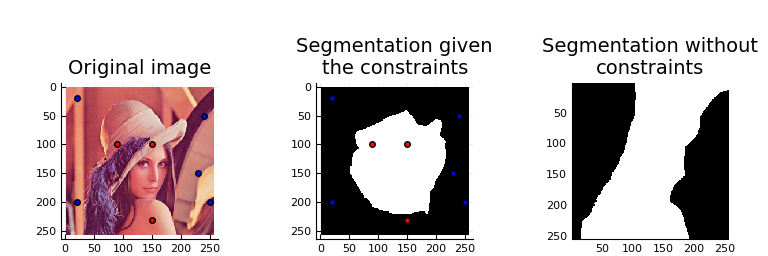

In [4]:
using TestImages, Images, Plots, SpectralClustering, Distances
pyplot()
function weight(i::Integer,j::Vector{<:Integer},pixel_i, neighbors_data)
    pos_sim = exp.((-Distances.colwise(SqEuclidean(),pixel_i[1:2], neighbors_data[1:2,:]))/(2*3^2))
    col_sim =  exp.(-Distances.colwise(SqEuclidean(), pixel_i[3:5],neighbors_data[3:5,:])./(2*0.2^2))
    return pos_sim .* col_sim
end
img         = testimage("lena_color_256");
nconfig     = PixelNeighborhood(3);
G           = create(Float64, nconfig, weight, img);
ng_vec      = embedding(NgLaplacian(2), G);
ng_vec      = ng_vec./ mapslices(norm,ng_vec,2);
lena_pixels = sub2ind(size(img), [100;100;230], [90;150;150]);
back_pixels = sub2ind(size(img), [200;200;50;20;150], [20;250;240;20;230]);
constraints = Vector{Integer}[lena_pixels,back_pixels ];
cg_vec      = embedding(PartialGroupingConstraints(3), G, constraints);
cg_vec      = cg_vec./ mapslices(norm,cg_vec,2);
img_ng      = RGB.(Gray.(imadjustintensity(reshape(ng_vec[:,1].<mean(ng_vec[:,1]),size(img))))) 
img_cg      = RGB.(Gray.(imadjustintensity(reshape(cg_vec[:,1].<mean(cg_vec[:,1]),size(img))))) 



using Measures
plt1 = Plots.plot(img, title="Original image", legend=false,top_margin=10.0mm); 
Plots.scatter!(plt1,[90;150;150],[100;100;230],c=:red, legend=false);
Plots.scatter!(plt1,[20;250;240;20;230],[200;200;50;20;150], c=:blue, legend=false);


plt2 = Plots.plot(img_cg, title="Segmentation given\nthe constraints",top_margin=10.0mm, legend=false); 
Plots.scatter!(plt2, [90;150;150],[100;100;230],c=:red, legend=false);
Plots.scatter!(plt2, [20;250;240;20;230],[200;200;50;20;150], c=:blue, legend=false);

plt3 = Plots.plot(img_ng, title="Segmentation without\nconstraints",top_margin=10.0mm);

Plots.plot(plt1, plt2,plt3,   layout =( @layout grid(1,3)), size=(size(img,1)*3,size(img,2))  )

## Negative weights
In the model proposed by [ref](#yu2001understanding) there are two non-negative weight matrices, $A$ and $R$. The matrix $A$ encodes the pairwise attraction, whereas, the matrix $R$ encodes the repulsion information. "The attraction measures the degree of association by feature similarity, the repulsion measures the segregation by feature dissimilarity".
The idea is  "having tight attraction within clusters and loose attraction between clusters at the same ime, strong repulsion between clusters and weak repulsion within clusters at the same time".

Let
$$\begin{array}{cc}
  W_{eq} &= A - R + D_R \\
   D_{eq} &= D_A + D_R
\end{array}$$
where $D_R = \text{diag}(R \mathbf{1})$ and $D_A = \text{diag}(A \mathbf{1})$ and

In the following example a set of trajectory segments is clusterized. [The dataset used](http://homepages.inf.ed.ac.uk/rbf/FORUMTRACKING/) consists of a set of detected targets of people walking through the Informatics Forum, the main building of the School of Informatics at the University of Edinburgh. The distance  $S(i,j)$ between two trajectory segments is defined according to [Trajectory clustering: a partition-and-group framework](#lee2007trajectorky).
$$\begin{array}{rl}
w_a(i,j) &= \exp\left(\dfrac{S(i,j)^2}{\sigma_a} \right) \\
w_a(i,j) &= 1- \exp\left(\dfrac{S(i,j)^2}{\sigma_r} \right) 
\end{array}$$


In [4]:
using SpectralClustering, Distances, StatsBase, Images, Plots, Extras.Trajectories, Colors, Extras
function wA(i::Integer,idx_neigh::Vector{<:Integer},t_i, neighbors_data, l_scale)
    local w = zeros(length(neighbors_data))
    for j=1:length(neighbors_data)
        local t_j = neighbors_data[j]
        w[j] = exp(-(distance(t_i,t_j)^2)/ ((l_scale[i] *l_scale[idx_neigh[j]])+0.00000001))
    end
    w[find(w.<0.01)] = 0
    return w
end
function wR(i::Idx, idx_neigh::Vector{Idx}, t_i, neighbors_data, l_scale) where Idx
    local w = zeros(length(neighbors_data))
    for j=1:length(neighbors_data)
        local t_j = neighbors_data[j]
        w[j] = 1-exp(-(distance(t_i,t_j)^2)/ ((l_scale[i] *l_scale[idx_neigh[j]])+0.00000001))     
    end
    return w
end


line_segments     = get_line_segments()
radius_attraction = 50
radius_repulsion  = 75
knnconfig_a       = KNNNeighborhood( line_segments, radius_attraction, x->Trajectories.center(x))
knnconfig_r       = KNNNeighborhood( line_segments, radius_repulsion, x->Trajectories.center(x))
l_scale_a         = local_scale(knnconfig_a, (t_1,t_2)->distance(t_1,t_2),  line_segments  )
l_scale_r         = local_scale(knnconfig_r, (t_1,t_2)->distance(t_1,t_2),line_segments  )
gra               = create(knnconfig_a, (i,j,v,n)->wA(i,j,v,n,l_scale_a), line_segments);
grr               = create(knnconfig_r, (i,j,v,n)->wR(i,j,v,n,l_scale_r), line_segments);
pop_vec           = embedding(YuShiPopout(5), gra,grr)
values            = [ (pop_vec[:,j] - minimum(pop_vec[:,j]) )./ (maximum(pop_vec[:,j]) - minimum(pop_vec[:,j]))  for j=1:3]
colors            = RGB[RGB(values[1][j], values[2][j], values[3][j]) for j=1:length(values[1]) ]
Plots.plot(line_segments, colors)

# References

In [6]:
using DocUtils
display("text/html",bibliography(["ng2002spectral","shi2000normalized","yu2001understanding"]))

<!DOCTYPE html PUBLIC "-//W3C//DTD HTML 4.01//EN">
 
 
 
 Bibliography 
 
 
 
 NJW002 
 Andrew Y Ng, Michael I Jordan, and Yair Weiss.
On spectral clustering: analysis and an algorithm.
In Advances in neural information processing systems . 2002. 
 SM000 
 Jianbo Shi and Jitendra Malik.
Normalized cuts and image segmentation.
 IEEE Transactions on pattern analysis and machine intelligence , 2000. 
 YS001 
 Stella X Yu and Jianbo Shi.
Understanding popout through repulsion.
In Computer Vision and Pattern Recognition, 2001. CVPR 2001. Proceedings of the 2001 IEEE Computer Society Conference on , volume 2. IEEE, 2001.